### GloVe embeddings (Pre-trained word embeddings)

### downloaded the raw dataset from " http://mng.bz/0tIo "

In [3]:
#download the imdb raw data and process the labels
import os
train_dir = r'C:\Users\v-nitbal\Documents\DL with Python - Francois Chollet\DL for text and sequences\aclImdb\test'

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)

In [6]:
len(texts)

17243

In [25]:
#tokenizing the text of the raw data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100
training_samples=7243
validation_samples=10000
max_words=10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [26]:
len(sequences)

17243

In [27]:
word_index = tokenizer.word_index
print("Found %s unique tokens."%len(word_index))

Found 72633 unique tokens.


In [28]:
data = pad_sequences(sequences, maxlen=maxlen)
data.shape

(17243, 100)

In [29]:
labels = np.asarray(labels)
labels.shape

(17243,)

In [30]:
#shuffle the data to prepare train and val data
indices = np.arange(data.shape[0])
indices

array([    0,     1,     2, ..., 17240, 17241, 17242])

In [31]:
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [32]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

In [33]:
len(x_train)

7243

### downloaded glove precomputed model from " https://nlp.stanford.edu/projects/glove"

In [35]:
#parsing the glove word-embeddings file
glove_dir = r'C:\Users\v-nitbal\Documents\DL with Python - Francois Chollet\DL for text and sequences\glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()
print("Found %s word vectors."%len(embeddings_index))

Found 400000 word vectors.


In [36]:
#preparing GloVe word-embeddings matrix
embedding_dim=100
embedding_matrix = np.zeros((max_words,embedding_dim))

for word,i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [38]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [40]:
#loading pre-trained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

In [41]:
#training and evaluating the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train,y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))

W1022 16:22:54.294680 11168 deprecation_wrapper.py:119] From C:\Users\v-nitbal\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1022 16:22:54.340165 11168 deprecation.py:323] From C:\Users\v-nitbal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7243 samples, validate on 10000 samples
Epoch 1/10
7243/7243 [==============================] - 41s 6ms/step - loss: 0.6338 - acc: 0.7235 - val_loss: 0.6161 - val_acc: 0.7234
Epoch 2/10
7243/7243 [==============================] - 38s 5ms/step - loss: 0.5749 - acc: 0.7247 - val_loss: 0.6114 - val_acc: 0.7229
Epoch 3/10
7243/7243 [==============================] - 37s 5ms/step - loss: 0.5325 - acc: 0.7311 - val_loss: 0.6121 - val_acc: 0.7191
Epoch 4/10
7243/7243 [==============================] - 37s 5ms/step - loss: 0.4994 - acc: 0.7548 - val_loss: 0.6758 - val_acc: 0.7169
Epoch 5/10
7243/7243 [==============================] - 35s 5ms/step - loss: 0.4376 - acc: 0.8037 - val_loss: 0.7355 - val_acc: 0.5532
Epoch 6/10
7243/7243 [==============================] - 34s 5ms/step - loss: 0.3922 - acc: 0.8317 - val_loss: 0.7520 - val_acc: 0.6684
Epoch 7/10
7243/7243 [==============================] - 34s 5ms/step - loss: 0.3341 - acc: 0.8644 - val_loss: 0.8129 - val_acc: 0.5988
Epoch 

In [42]:
model.save('pre-trained GloVe.h5')

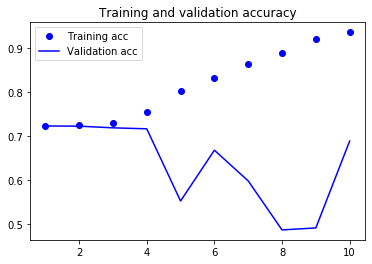

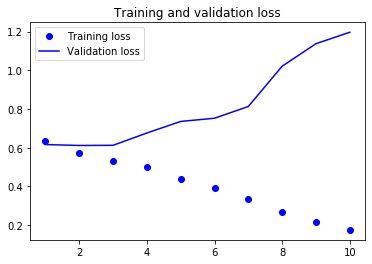

In [44]:
#visualize accuracy and loss during training
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### This is overfitting 